In [52]:
import glob
import tensorflow as tf
import cv2
from PIL import Image
from io import BytesIO
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from d2l import torch as d2l
import torch
import io

In [53]:
train_files = glob.glob('tpu-getting-started/*/train/*.tfrec')
val_files = glob.glob('tpu-getting-started/*/val/*.tfrec')
test_files = glob.glob('tpu-getting-started/*/test/*.tfrec')

In [54]:
train_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, train_feature_description)

train_ids = []
train_class = []
train_images = []

for i in train_files:
  train_image_dataset = tf.data.TFRecordDataset(i)

  train_image_dataset = train_image_dataset.map(_parse_image_function)

  ids = [str(id_features['id'].numpy())[2:-1] for id_features in train_image_dataset] # [2:-1] is done to remove b' from 1st and 'from last in train id names
  train_ids = train_ids + ids

  classes = [int(class_features['class'].numpy()) for class_features in train_image_dataset]
  train_class = train_class + classes

  images = [image_features['image'].numpy() for image_features in train_image_dataset]
  train_images = train_images + images

In [55]:
val_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, val_feature_description)

val_ids = []
val_class = []
val_images = []

for i in val_files:
    val_image_dataset = tf.data.TFRecordDataset(i)

    val_image_dataset = val_image_dataset.map(_parse_image_function)

    ids = [str(image_features['id'].numpy())[2:-1] for image_features in val_image_dataset]
    val_ids += ids

    classes = [int(image_features['class'].numpy()) for image_features in val_image_dataset]
    val_class += classes

    images = [image_features['image'].numpy() for image_features in val_image_dataset]
    val_images += images

In [56]:
test_feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_test(example_proto):
    return tf.io.parse_single_example(example_proto, test_feature_description)

test_ids = []
test_images = []
for i in test_files:
    test_image_dataset = tf.data.TFRecordDataset(i)

    test_image_dataset = test_image_dataset.map(_parse_image_function_test)

    ids = [str(id_features['id'].numpy())[2:-1] for id_features in test_image_dataset]
    test_ids = test_ids + ids

    images = [image_features['image'].numpy() for image_features in test_image_dataset]
    test_images = test_images + images

In [57]:
print(len(train_ids))
print(len(train_class))
print(len(train_images))
print(len(val_ids))
print(len(test_ids))

51012
51012
51012
14848
29528


In [58]:
#种类个数
train_set = set(train_class)
print(len(train_set))
val_set = set(val_class)
print(len(val_set))

104
104


In [59]:
test = BytesIO(train_images[1])
# test = Image.open(test)
#
# test.show()

In [60]:
class MyDataset():
    def __init__(self, ids, cls, imgs, transforms, is_test=False):
        self.ids = ids
        if not is_test:
            self.cls = cls
        self.imgs = imgs
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = Image.open(io.BytesIO(img))
        img = self.transforms(img)
        if self.is_test:
            return img,
        return img, int(self.cls[idx])

In [61]:
transforms = transforms.Compose([
                        transforms.Resize(96),

                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])

In [73]:
train_ds = MyDataset(train_ids, train_class, train_images, transforms)
valid_ds = MyDataset(val_ids, val_class, val_images, transforms)
test_ds = MyDataset(test_ids, None, test_images, transforms,is_test=True)

In [74]:
trainloader = DataLoader(train_ds,batch_size=128,shuffle=True,num_workers=2)
validloader = DataLoader(valid_ds,batch_size=128,shuffle=True,num_workers=2)
testloader = DataLoader(test_ds,batch_size=128,shuffle=False,num_workers=2)

In [64]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用 GPU 在数据集上计算模型的准确度。"""
    if isinstance(net, nn.Module):
        net.eval()  # 将模型设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT 微调所需
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]
def train_test(net, train_iter, test_iter, num_epochs,device = None):
    """训练并测试参数"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters())

#     optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失总和、训练准确率总和、示例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X= X.to(device)
            y = y.to(device)

#             X = X.cuda()
#             y = y.cuda()
#             print(X.device,y.device)
#             y_hat,test = net(X.to(device))
#             y_hat = y_hat.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))

        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [65]:
def train(net, train_iter,num_epochs,device = None):
    """训练并保存模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters())

#     optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失总和、训练准确率总和、示例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X= X.to(device)
            y = y.to(device)

#             X = X.cuda()
#             y = y.cuda()
#             print(X.device,y.device)
#             y_hat,test = net(X.to(device))
#             y_hat = y_hat.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
    torch.save(net,r'train.pth')
def test(test_iter, device = None,trainfile_dir='gender_Classification.pth'):
    """读取并测试模型"""
    net = torch.load(trainfile_dir)
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    print(test_acc)

In [66]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 104))

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loss 0.526, train acc 0.854, test acc 0.599
2090.0 examples/sec on cuda:0


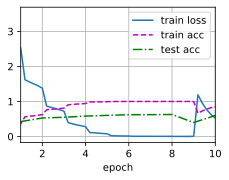

In [51]:
num_epochs=10
train_test(net,trainloader,validloader,num_epochs,device)

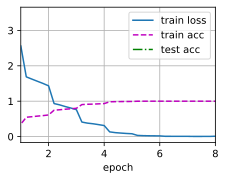

In [68]:
num_epochs=8
# train_test(net,trainloader,testloader, num_epochs,device)
train(net,trainloader, num_epochs,device)

In [90]:
from torch.autograd import Variable
testnet = torch.load('train.pth')
def prediciton(model,data_loader,device):
    model.eval()
    test_pred = torch.LongTensor()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
        
#             data = Variable(data, volatile=True)

#             if torch.cuda.is_available():
#                 data = data.cuda()
            if isinstance(data, list):
                # BERT 微调所需
                data = [x.to(device) for x in data]
            else:
                data = data.to(device)
            
            output = model(data)
        
            pred = output.cpu().data.max(1, keepdim=True)[1]
            test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred


In [91]:
test_pred = prediciton(testnet,testloader,device)

<ipython-input-90-d687298cea24>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True)


TypeError: Variable data has to be a tensor, but got list